In [1]:
import numpy as np
import cv2
from google.colab import drive
drive.mount('/content/gdrive')
from tensorflow.keras.models import load_model

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


**Face Detection Using a Pre-trained Network**

In [0]:
class FaceDetector(object):
    def __init__(self, path_to_prototxt='../Model/deploy.prototxt', 
                 path_to_caffemodel = '../Model/res10_300x300_ssd_iter_140000.caffemodel'):
        self.detection_network = \
            cv2.dnn.readNetFromCaffe(path_to_prototxt,
                                     path_to_caffemodel)

    def face_detect(self, image, desired_confidence=0.9):
        blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
        self.detection_network.setInput(blob)
        detections = self.detection_network.forward()
        face_frames_coordinates=[]
        (h, w) = image.shape[:2]
        for i in range(0, detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            if confidence > desired_confidence:  
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (xmin, ymin, xmax, ymax) = box.astype("int")
                face_frames_coordinates.append((xmin, ymin, xmax, ymax))
        return face_frames_coordinates

**Preparation of facial images for transmission to an artificial neural network. Optional: face image alignment.**

In [0]:
class FacePreprocessor(object):
    def __init__(self, path_to_CascadeClassifier="../Model/cascade.xml", use_alignment=True,  leave_blank_areas=False):
        self.use_alignment = use_alignment
        self.leave_blank_areas = leave_blank_areas
        if self.use_alignment:
            self.eye_cascade = cv2.CascadeClassifier(path_to_CascadeClassifier)
    #  TODO: Вынести некостанаты на уровень конструктора        
    def preprocess(self, image, face_frames_coordinates, output_image_shape=(48,48)): 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        if self.use_alignment:
            aligned_faces = []
            for xmin, ymin, xmax, ymax in face_frames_coordinates:
                transformed_image = self.transform_if_possible((xmin, ymin, xmax, ymax), image)
                image_after_resize = cv2.resize(transformed_image, output_image_shape)
                normalized_image = self.normalize(image_after_resize)
                aligned_faces.append(normalized_image)
                
            return np.array(aligned_faces)
        else:
            faces = np.array([cv2.resize(image[ymin:ymax,xmin:xmax], output_image_shape) 
            for xmin, ymin, xmax, ymax in face_frames_coordinates])
        return faces

    def transform_if_possible(self, face_frame_coordinates, image, shape_for_haar=(150,150)):
        eyes_coordinates = self.search_eyes(self.cut_face(image,  face_frame_coordinates), shape_for_haar)
        if len(eyes_coordinates) > 1:
            rotation_matrix = self.get_rotation_parameters(eyes_coordinates, 
                                                           face_frame_coordinates, shape_for_haar)
            return self.transform(image, rotation_matrix, face_frame_coordinates)
        else:
            xmin, ymin, xmax, ymax = face_frame_coordinates
            return image[ymin:ymax,xmin:xmax]
                
    def search_eyes(self, face, shape_for_haar):
        face = cv2.resize(face, shape_for_haar)
        eyes = self.eye_cascade.detectMultiScale(face[0:95], 1.02, minSize=(20, 20), maxSize=(50, 50))
        eyes_coordinates = [(x + w//2, y + h//2) for x, y, w, h in eyes[:2]]
        eyes_coordinates.sort()
        return eyes_coordinates

    def cut_face(self, image,  face_frame_coordinates):
        xmin, ymin, xmax, ymax = face_frame_coordinates
        return image[ymin:ymax,xmin:xmax]    

    def get_rotation_parameters(self, eyes_coordinates, face_frame_coordinates, shape_for_haar, scale=0.8):
        xmin, ymin, xmax, ymax = face_frame_coordinates
        dx = eyes_coordinates[1][0] - eyes_coordinates[0][0]
        dy = eyes_coordinates[1][1] - eyes_coordinates[0][1]
        angle = np.degrees(np.arctan2(dy, dx))
        coordinates_of_point_between_eyes = ((eyes_coordinates[0][0]+eyes_coordinates[1][0])//2,
                                                 (eyes_coordinates[0][1]+eyes_coordinates[1][1])//2)
        relative_x = coordinates_of_point_between_eyes[0] / 150 
        relative_y = coordinates_of_point_between_eyes[1] / 150
        coordinates_of_point_between_eyes_on_origin_face = \
            (int((xmax - xmin) * relative_x), int((ymax - ymin) * relative_y))
        pivot_point_coordinates = (xmin \
                                    + coordinates_of_point_between_eyes_on_origin_face[0],
                                   ymin \
                                    + coordinates_of_point_between_eyes_on_origin_face[1])
        rotation_matrix = cv2.getRotationMatrix2D(pivot_point_coordinates, angle, scale)
        desired_position_of_point_between_eyes_in_image_x = shape_for_haar[1] * 0.45 
        rotation_matrix[0, 2] += (desired_position_of_point_between_eyes_in_image_x \
                                  - coordinates_of_point_between_eyes[0])
        return rotation_matrix
    
    def transform(self, image, rotation_matrix, face_frame_coordinates):
        xmin, ymin, xmax, ymax = face_frame_coordinates
        rotated_image = cv2.warpAffine(image, rotation_matrix, image.shape[:2], flags=cv2.INTER_CUBIC)
        face = rotated_image[ymin:ymax,xmin:xmax]
        return face

    def normalize(self, face_image):
        return face_image / 255

**Download and configure image classifier**

In [0]:
class FaceEmotionRecognizer(object):
    def __init__(self, path_to_network_model="../Model/best_autokeras_model.h5"):
        self.model=load_model(path_to_network_model)

    def emotion_recognize(self, face_images):
        face_image_list = np.expand_dims(face_images, axis=-1)
        return self.model.predict(face_image_list) 

**TEST**

In [0]:
from google.colab.patches import cv2_imshow
image = cv2.imread(r'/content/gdrive/My Drive/Data/example.png')

250 42 319 144 [0. 1. 0. 0. 0. 0. 0.]
366 386 438 480 [1. 0. 0. 0. 0. 0. 0.]
368 214 435 324 [0. 1. 0. 0. 0. 0. 0.]
18 210 88 309 [1. 0. 0. 0. 0. 0. 0.]
22 46 93 142 [8.33787e-15 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 1.00000e+00
 0.00000e+00]
129 39 203 137 [0. 0. 1. 0. 0. 0. 0.]
369 45 434 138 [1. 0. 0. 0. 0. 0. 0.]
135 394 206 486 [1. 0. 0. 0. 0. 0. 0.]
246 391 319 492 [5.576027e-28 1.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 0.000000e+00 0.000000e+00]
136 216 208 314 [0. 1. 0. 0. 0. 0. 0.]
476 383 546 485 [0. 1. 0. 0. 0. 0. 0.]
477 218 547 320 [1. 0. 0. 0. 0. 0. 0.]
25 403 91 498 [0. 1. 0. 0. 0. 0. 0.]
250 216 320 314 [0. 0. 1. 0. 0. 0. 0.]
476 42 548 157 [1. 0. 0. 0. 0. 0. 0.]


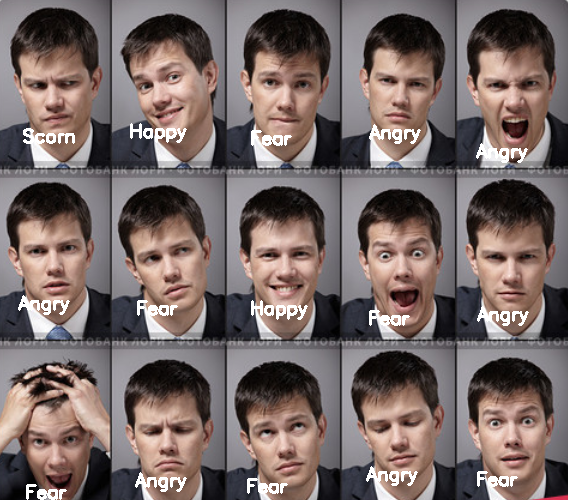

In [12]:
detector = FaceDetector(r'/content/gdrive/My Drive/Models/deploy.prototxt',
                        r'/content/gdrive/My Drive/Models/res10_300x300_ssd_iter_140000.caffemodel')
preprocessor = FacePreprocessor(r'/content/gdrive/My Drive/Models/cascade.xml', use_alignment=False)
emotion_recognizer = FaceEmotionRecognizer(r'/content/gdrive/My Drive/Models/model_self.h5')

emotion_list = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Scorn', 'Surprise']
tmp_image = image.copy()
face_frames_coordinates = detector.face_detect(tmp_image) # Координаты лиц
value = emotion_recognizer.emotion_recognize(preprocessor.preprocess(tmp_image, face_frames_coordinates))
draw_list = list(zip(face_frames_coordinates, value))
if len(face_frames_coordinates) > 0:
    for (xmin, ymin, xmax, ymax), emotion in draw_list:
        print(xmin, ymin, xmax, ymax, emotion)
        #cv2.rectangle(tmp_image, (xmin, ymin), (xmax, ymax), (210,50,22), 2)
        cv2.putText(tmp_image, emotion_list[np.where(emotion == np.max(emotion))[0][0]] , (xmin, ymax), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    cv2_imshow(tmp_image)

    

In [0]:
for face in preprocessor.preprocess(image, detector.face_detect(image)):
    cv2_imshow(face.astype(int))
print(emotion_recognizer.emotion_recognize(preprocessor.preprocess(image, 
                                                                   detector.face_detect(image))))  

**Классификация эмоций на изображении в реальном времени**

In [0]:
cap = cv2.VideoCapture(0)
detector = FaceDetector(r'/content/gdrive/My Drive/Models/deploy.prototxt',
                        r'/content/gdrive/My Drive/Models/res10_300x300_ssd_iter_140000.caffemodel')
preprocessor = FacePreprocessor(r'/content/gdrive/My Drive/Models/cascade.xml', use_alignment=False)
emotion_recognizer = FaceEmotionRecognizer(r'/content/gdrive/My Drive/Models/model_self.h5')
while 1:
    ret, image = cap.read()
    emotion_list = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sadness', 'Scorn', 'Surprise']
    image = image.copy()
    face_frames_coordinates = detector.face_detect(image) # Координаты лиц
    value = emotion_recognizer.emotion_recognize(preprocessor.preprocess(image, face_frames_coordinates))
    draw_list = list(zip(face_frames_coordinates, value))
    if len(face_frames_coordinates) > 0:
        for (xmin, ymin, xmax, ymax), emotion in draw_list:
            print(xmin, ymin, xmax, ymax, emotion)
            #cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (210,50,22), 2)
            cv2.putText(image, emotion_list[np.where(emotion == np.max(emotion))[0][0]], 
                        (xmin, ymax), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
        cv2_imshow(image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()